In [1]:
import pandas as pd
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [3]:
data = pd.read_csv('C:/Users/Yogeshwar/Downloads/combine_data.csv')

In [5]:
data.shape

(2225, 2)

In [7]:
texts=[]

In [9]:
texts_summ=[]

In [11]:
def get_text(i,j):
    text1 = ""
    ref = ""
    for k in range(i,j):
        ref+=data['Reference'][k]
        text1+=data['Text'][k]
        
    texts.append(text1)
    texts_summ.append(ref)
        

In [13]:
for i in range(10):
    get_text(10*i,10*(i+1))

In [15]:
def calculate_redundancy(similarity_matrix, decision_vector):
        n = len(decision_vector)
        redundancy = 0
        count = 0
        for i in range(n):
            if decision_vector[i] == 1:
                for j in range(i + 1, n):
                    if decision_vector[j] == 1:
                        redundancy += similarity_matrix[i][j]
                        count += 1
        return redundancy / count if count > 0 else 0

def calculate_coverage(similarity_matrix, decision_vector):
    coverage = 0
    n = len(decision_vector)
    for i in range(len(decision_vector)):
        ans = 0
        if decision_vector[i] == 1:
            for j in range(n):
                if i != j:
                    ans += abs(similarity_matrix[i][j])
            coverage += ans
    return -coverage/n

In [37]:
import subprocess
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.mutation import Mutation
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.termination.default import DefaultMultiObjectiveTermination

# Define the optimization problem, algorithm, and other necessary classes here (as in your previous code)

# Function to save solutions to a file
def save_population_to_file(filename, population):
    # Save population objectives or decision vectors to a file in the format expected by entropy_measure
    with open(filename, 'w') as f:
        for ind in population:
            f.write(" ".join(map(str, ind)) + "\n")

# Function to call the entropy measure script
def run_entropy_script(num_obj, num_bins, parent_file, child_file):
    # Construct the command to run the script
    command1 = f"./entropy_measure/Release make clean"
    command2 =  f"./entropy_measure/Release make"
    command = f"./entropy_measure/Release/entropy_measure {num_obj} {num_bins} {parent_file} {child_file}"
    # Run the script and capture the output
    subprocess.run(command1, shell=True, capture_output=True, text=True)
    subprocess.run(command2, shell=True, capture_output=True, text=True)
    process = subprocess.run(command, shell=True, capture_output=True, text=True)
    # Print or process the output
    print(process.stdout)  # This will show the I, O, D values

# Sample integration in the optimization loop
def integrate_script_in_optimization(problem):
    # Initialize your problem and algorithm as previously set up
    algorithm = NSGA2(
        pop_size=20,
        sampling=sampling1(fixed_num_ones, n),  # Assuming sampling1 is defined
        crossover=HalfUniformCrossover(),
        mutation=BitflipMutation(prob=0.2),  # Assuming BitflipMutation is defined
        eliminate_duplicates=True
    )
    termination = DefaultMultiObjectiveTermination(n_max_gen=1000)
    
    # Minimize the problem
    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    for gen in range(len(res.history)):
        # Get current and previous populations (example: current population is the child)
        current_pop = algorithm.pop.get("X")  # Get decision vectors of the current population
        previous_pop = res.history[gen - 1].pop.get("X") if gen > 0 else current_pop

        # Save populations to files
        save_population_to_file("parent_file.txt", previous_pop)
        save_population_to_file("child_file.txt", current_pop)

        # Run the entropy script with the saved files
        run_entropy_script(number_objectives=3, number_bins=20,  # Adjust these values as needed
                           parent_file="parent_file.txt", 
                           child_file="child_file.txt")


In [39]:
import subprocess
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.core.mutation import Mutation

# Define the problem, mutation, and other necessary classes here as in your previous code

# Function to save solutions to a file

# Define the main function to run the optimization
def integrate_script_in_optimization():
    problem = RedundancyCoverageProblem()  # Assuming this is defined in your earlier code
    algorithm = NSGA2(
        pop_size=20,
        sampling=sampling1(fixed_num_ones, n),  # Assuming sampling1 is defined
        crossover=HalfUniformCrossover(),
        mutation=BitflipMutation(prob=0.2),  # Assuming BitflipMutation is defined
        eliminate_duplicates=True
    )

    termination = DefaultMultiObjectiveTermination(n_max_gen=1000)

    # Run the optimization with the custom callback
    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   callback=EntropyCallback(),  # Use the callback here
                   save_history=True,
                   verbose=True)

# Call the function to run the optimization and integrate the script
integrate_script_in_optimization()

NameError: name 'RedundancyCoverageProblem' is not defined

In [115]:
import subprocess
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.core.mutation import Mutation
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.visualization.scatter import Scatter
import pandas as pd
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from pymoo.core.callback import Callback
from nltk.tokenize import sent_tokenize
import os

In [1]:
    
    
    # Define necessary functions
def get_sol(texts, texts_summ):
    sentences = sent_tokenize(texts)
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    embeddings = model.encode(sentences)
    similarity_matrix = cosine_similarity(embeddings)
    
    def sampling1(fixed_num_ones, n):
    samples = []
    for _ in range(100):
    sample = np.zeros(n)
    sample[:fixed_num_ones] = 1
    np.random.shuffle(sample)
    samples.append(sample)
    return np.array(samples)
    
    fixed_num_ones = len(sentences) // 3
    n = len(sentences)
    
    class EntropyCallback(Callback):
    def __init__(self):
    super().__init__()
    
    def notify(self, algorithm):
    # Define how you want to execute the script
    self.execute_script()
    
    def execute_script(self):
    # Change to the directory containing the script
    os.chdir("C:/Users/Yogeshwar/Desktop/EMO/entropy_dissimilarity_measure")
    
    # Run the shell script
    subprocess.run(["bash", "entropy_script.sh"], check=True)
    
    # Change back to the original directory
    os.chdir("..")
    
    class RedundancyCoverageProblem(ElementwiseProblem):
    def __init__(self):
    xl = np.zeros(n)
    xu = np.ones(n)
    super().__init__(n_var=n, n_obj=2, n_ieq_constr=1, xl=xl, xu=xu)
    
    def _evaluate(self, x, out, *args, **kwargs):
    f1 = calculate_redundancy(similarity_matrix, x)
    f2 = calculate_coverage(similarity_matrix, x)
    out["F"] = np.column_stack([f1, f2])
    g = np.sum(x) - fixed_num_ones
    out["G"] = np.array([g])
    
    class BitflipMutation(Mutation):
    def __init__(self, prob=None):
    super().__init__()
    self.prob = prob
    
    def _do(self, problem, X, **kwargs):
    Xp = np.copy(X)
    for i in range(len(Xp)):
    for j in range(problem.n_var):
        if np.random.random() < self.prob:
            Xp[i, j] = 1 - Xp[i, j]  # Flip the bit
    return Xp
    
    problem = RedundancyCoverageProblem()
    callback = EntropyCallback()
    algorithm = NSGA2(
    pop_size=40,
    sampling=sampling1(fixed_num_ones, n),
    crossover=HalfUniformCrossover(),
    mutation=BitflipMutation(prob=0.2),
    eliminate_duplicates=True
    )
    
    termination = DefaultMultiObjectiveTermination(n_max_gen=1000)
    res = minimize(problem,
       algorithm,
       termination,
       seed=1,
       save_history=True,
       callback=EntropyCallback(),
       verbose=True)
    
    Final_solution = res.X
    result = []
    result.append(res.F)
    f1 = res.F[:, 1]  # Redundancy
    f2 = res.F[:, 0]  # Coverage
    result.append([f1, f2])
    plt.scatter(f1, f2)
    plt.xlabel('Coverage')
    plt.ylabel('Redundancy')
    plt.show()
    
    def generate_summary(decision_vector, sentences):
    return " ".join([sentence for idx, sentence in enumerate(sentences) if decision_vector[idx] == 1])
    
    summaries = [generate_summary(dv, sentences) for dv in Final_solution]
    
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    def calculate_rouge_scores(generated_summaries, reference_summary):
    scores_list = []
    for gen_summary in generated_summaries:
    scores = scorer.score(gen_summary, reference_summary)
    scores_list.append(scores)
    return scores_list
    
    rouge_scores = calculate_rouge_scores(summaries, texts_summ)
    
    data1 = []
    for idx, scores in enumerate(rouge_scores):
    f1_score = scores['rouge1'].fmeasure
    f2_score = scores['rouge2'].fmeasure
    fl_score = scores['rougeL'].fmeasure
    data1.append([idx + 1, f1_score, f2_score, fl_score])
    
    df = pd.DataFrame(data1, columns=['Summary', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
    rouge_max = [df['ROUGE-1'].max(), df['ROUGE-2'].max(), df['ROUGE-L'].max()]
    
    bar_width = 0.25
    r1 = range(len(df))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    plt.figure(figsize=(20, 5))
    plt.bar(r1, df['ROUGE-1'], color='b', width=bar_width, edgecolor='grey', label='ROUGE-1')
    plt.bar(r2, df['ROUGE-2'], color='r', width=bar_width, edgecolor='grey', label='ROUGE-2')
    plt.bar(r3, df['ROUGE-L'], color='g', width=bar_width, edgecolor='grey', label='ROUGE-L')
    
    plt.xlabel('Summaries', fontweight='bold')
    plt.ylabel('ROUGE Scores', fontweight='bold')
    plt.title('ROUGE Scores for Each Summary')
    plt.xticks([r + bar_width for r in range(len(df))], df['Summary'])
    plt.legend()
    
    plt.show()


IndentationError: expected an indented block after function definition on line 2 (156925814.py, line 3)

In [109]:

# Call the function to run the optimization and integrate the script
def get_sol(texts, texts_summ):
    sentences = sent_tokenize(texts)
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    embeddings = model.encode(sentences)
    similarity_matrix = cosine_similarity(embeddings)

    def sampling1(fixed_num_ones, n):
        samples = []
        for _ in range(100):
            sample = np.zeros(n)
            sample[:fixed_num_ones] = 1
            np.random.shuffle(sample)
            samples.append(sample)
        return np.array(samples)

    fixed_num_ones = len(sentences) // 3
    n = len(sentences)

    # def save_population_to_file(filename, population):
    #     with open(filename, 'w') as f:
    #         for ind in population:
    #             f.write(" ".join(map(str, ind)) + "\n")

    # def run_entropy_script(num_obj, num_bins, parent_file, child_file):
    #     command = f"C:/Users/Yogeshwar/Desktop/EMO/entropy_dissimilarity_measure/entropy_measure/Release/entropy_measure {num_obj} {num_bins} {parent_file} {child_file}"
    #     process = subprocess.run(command, shell=True, capture_output=True, text=True)
    #     output = process.stdout
    #     print(output)
    #     output= str(output)
    #     print(type(output))
    #     return output

    # def parse_entropy_output(output):
    #     # Split the output into lines and parse each line
    #     lines = output.strip().split('\n')
    #     entropy_values = {}
        
    #     for line in lines:
    #         if line.startswith('I:'):
    #             entropy_values['I'] = float(line.split(':')[1].strip())
    #         elif line.startswith('O:'):
    #             entropy_values['O'] = float(line.split(':')[1].strip())
    #         elif line.startswith('D:'):
    #             entropy_values['D'] = float(line.split(':')[1].strip())
        
    #     # Debugging: print parsed values
    #     print("Parsed Entropy Values:", entropy_values)
        
    #     return entropy_values


    from pymoo.core.callback import Callback

    # class EntropyCallback(Callback):
    #     def __init__(self):
    #         super().__init__()
        
    #     def notify(self, algorithm):
    #     # Define how you want to execute the script
    #         self.execute_script()
        
    #     def execute_script(self):
    #     # Change to the directory containing the script
        
    #     # Run the shell script
    #         subprocess.run("C:/Users/Yogeshwar/Desktop/EMO/entropy_dissimilarity_measure ",check=True)
        
    #     # Change back to the original directory
    
    #         # Check if termination flag is set
            
            



    class RedundancyCoverageProblem(ElementwiseProblem):
        def __init__(self):
            xl = np.zeros(n)
            xu = np.ones(n)
            super().__init__(n_var=n, n_obj=2, n_ieq_constr=1, xl=xl, xu=xu)

        def _evaluate(self, x, out, *args, **kwargs):
            f1 = calculate_redundancy(similarity_matrix, x)
            f2 = calculate_coverage(similarity_matrix, x)
            out["F"] = np.column_stack([f1, f2])
            g = np.sum(x) - fixed_num_ones
            out["G"] = np.array([g])

    class BitflipMutation(Mutation):
        def __init__(self, prob=None):
            super().__init__()
            self.prob = prob

        def _do(self, problem, X, **kwargs):
            Xp = np.copy(X)
            for i in range(len(Xp)):
                for j in range(problem.n_var):
                    if np.random.random() < self.prob:
                        Xp[i, j] = 1 - Xp[i, j]  # Flip the bit
            return Xp

    problem = RedundancyCoverageProblem()

    algorithm = NSGA2(
        pop_size=20,
        sampling=sampling1(fixed_num_ones, n),
        crossover=HalfUniformCrossover(),
        mutation=BitflipMutation(prob=0.2),
        eliminate_duplicates=True
    )
    
    termination = DefaultMultiObjectiveTermination(n_max_gen=100)
    # callback = EntropyCallback()  # Set a threshold for dissimilarity change
    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   # callback=callback,
                   verbose=True)

    Final_solution = res.X
    result = []
    result.append(res.F)
    f1 = res.F[:, 1]  # Redundancy
    f2 = res.F[:, 0]  # Coverage
    result.append([f1, f2])
    plt.scatter(f1, f2)
    plt.xlabel('Coverage')
    plt.ylabel('Redundancy')
    plt.show()

    def generate_summary(decision_vector, sentences):
        return " ".join([sentence for idx, sentence in enumerate(sentences) if decision_vector[idx] == 1])

    summaries = [generate_summary(dv, sentences) for dv in Final_solution]

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def calculate_rouge_scores(generated_summaries, reference_summary):
        scores_list = []
        for gen_summary in generated_summaries:
            scores = scorer.score(gen_summary, reference_summary)
            scores_list.append(scores)
        return scores_list

    rouge_scores = calculate_rouge_scores(summaries, texts_summ)

    data1 = []
    for idx, scores in enumerate(rouge_scores):
        f1_score = scores['rouge1'].fmeasure
        f2_score = scores['rouge2'].fmeasure
        fl_score = scores['rougeL'].fmeasure
        data1.append([idx + 1, f1_score, f2_score, fl_score])

    df = pd.DataFrame(data1, columns=['Summary', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
    rouge_max = [df['ROUGE-1'].max(), df['ROUGE-2'].max(), df['ROUGE-L'].max()]

    bar_width = 0.25
    r1 = range(len(df))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.figure(figsize=(20, 5))
    plt.bar(r1, df['ROUGE-1'], color='b', width=bar_width, edgecolor='grey', label='ROUGE-1')
    plt.bar(r2, df['ROUGE-2'], color='r', width=bar_width, edgecolor='grey', label='ROUGE-2')
    plt.bar(r3, df['ROUGE-L'], color='g', width=bar_width, edgecolor='grey', label='ROUGE-L')

    plt.xlabel('Summaries', fontweight='bold')
    plt.ylabel('ROUGE Scores', fontweight='bold')
    plt.title('ROUGE Scores for Each Summary')
    plt.xticks([r + bar_width for r in range(len(df))], df['Summary'])
    plt.legend()

    plt.show()



In [123]:
import numpy as np
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from pymoo.optimize import minimize
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.mutation import Mutation
from pymoo.operators.crossover import HalfUniformCrossover
from pymoo.termination import DefaultMultiObjectiveTermination
from pymoo.core.callback import Callback
from nltk.tokenize import sent_tokenize
from rouge_score import rouge_scorer

def get_sol(texts, texts_summ):
    sentences = sent_tokenize(texts)
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    embeddings = model.encode(sentences)
    similarity_matrix = cosine_similarity(embeddings)

    def sampling1(fixed_num_ones, n):
        samples = []
        for _ in range(100):
            sample = np.zeros(n)
            sample[:fixed_num_ones] = 1
            np.random.shuffle(sample)
            samples.append(sample)
        return np.array(samples)

    fixed_num_ones = len(sentences) // 3
    n = len(sentences)

    def save_population_to_file(filename, population):
        np.savetxt(filename, population, delimiter=" ", fmt="%f")

    class EntropyCallback(Callback):
        def __init__(self):
            super().__init__()
            self.termination_threshold = 0.01  # Define your termination threshold
            self.prev_pop_file = "ctp1_moea_1.out"
            self.curr_pop_file = "ctp1_moea_2.out"

        def notify(self, algorithm):
            self.execute_script(algorithm)

        def execute_script(self, algorithm):
            if hasattr(algorithm, 'history') and len(algorithm.history) > 0:
                # Save previous and current populations
                parent_pop = algorithm.history[-1].pop.get("F") if len(algorithm.history) > 1 else None
                curr_pop = algorithm.pop.get("F")

                if parent_pop is not None:
                    save_population_to_file(self.prev_pop_file, parent_pop)
                save_population_to_file(self.curr_pop_file, curr_pop)

                # Execute the script
                command = f"sh C:/Users/Yogeshwar/Desktop/EMO/entropy_dissimilarity_measure/entropy_script.sh {self.prev_pop_file} {self.curr_pop_file}"
                process = subprocess.run(command, shell=True, capture_output=True, text=True)
                output = process.stdout
                print("Script Output:", output)
                
                # Parse output to check for termination condition
                entropy_values = self.parse_entropy_output(output)
                if entropy_values['D'] < self.termination_threshold:
                    algorithm.termination.n_max_gen = algorithm.n_gen  # Force termination

        def parse_entropy_output(self, output):
            lines = output.strip().split('\n')
            entropy_values = {}
            for line in lines:
                if line.startswith('I:'):
                    entropy_values['I'] = float(line.split(':')[1].strip())
                elif line.startswith('O:'):
                    entropy_values['O'] = float(line.split(':')[1].strip())
                elif line.startswith('D:'):
                    entropy_values['D'] = float(line.split(':')[1].strip())
            return entropy_values

    class RedundancyCoverageProblem(ElementwiseProblem):
        def __init__(self):
            xl = np.zeros(n)
            xu = np.ones(n)
            super().__init__(n_var=n, n_obj=2, n_ieq_constr=1, xl=xl, xu=xu)

        def _evaluate(self, x, out, *args, **kwargs):
            f1 = calculate_redundancy(similarity_matrix, x)
            f2 = calculate_coverage(similarity_matrix, x)
            out["F"] = np.column_stack([f1, f2])
            g = np.sum(x) - fixed_num_ones
            out["G"] = np.array([g])

    class BitflipMutation(Mutation):
        def __init__(self, prob=None):
            super().__init__()
            self.prob = prob

        def _do(self, problem, X, **kwargs):
            Xp = np.copy(X)
            for i in range(len(Xp)):
                for j in range(problem.n_var):
                    if np.random.random() < self.prob:
                        Xp[i, j] = 1 - Xp[i, j]  # Flip the bit
            return Xp

    problem = RedundancyCoverageProblem()

    algorithm = NSGA2(
        pop_size=20,
        sampling=sampling1(fixed_num_ones, n),
        crossover=HalfUniformCrossover(),
        mutation=BitflipMutation(prob=0.2),
        eliminate_duplicates=True
    )
    
    termination = DefaultMultiObjectiveTermination(n_max_gen=100)
    callback = EntropyCallback()

    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   callback=callback,
                   verbose=True)

    Final_solution = res.X
    result = []
    result.append(res.F)
    f1 = res.F[:, 1]  # Redundancy
    f2 = res.F[:, 0]  # Coverage
    result.append([f1, f2])
    plt.scatter(f1, f2)
    plt.xlabel('Coverage')
    plt.ylabel('Redundancy')
    plt.show()

    def generate_summary(decision_vector, sentences):
        return " ".join([sentence for idx, sentence in enumerate(sentences) if decision_vector[idx] == 1])

    summaries = [generate_summary(dv, sentences) for dv in Final_solution]

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def calculate_rouge_scores(generated_summaries, reference_summary):
        scores_list = []
        for gen_summary in generated_summaries:
            scores = scorer.score(gen_summary, reference_summary)
            scores_list.append(scores)
        return scores_list

    rouge_scores = calculate_rouge_scores(summaries, texts_summ)

    data1 = []
    for idx, scores in enumerate(rouge_scores):
        f1_score = scores['rouge1'].fmeasure
        f2_score = scores['rouge2'].fmeasure
        fl_score = scores['rougeL'].fmeasure
        data1.append([idx + 1, f1_score, f2_score, fl_score])

    df = pd.DataFrame(data1, columns=['Summary', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
    rouge_max = [df['ROUGE-1'].max(), df['ROUGE-2'].max(), df['ROUGE-L'].max()]

    bar_width = 0.25
    r1 = range(len(df))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.figure(figsize=(20, 5))
    plt.bar(r1, df['ROUGE-1'], color='b', width=bar_width, edgecolor='grey', label='ROUGE-1')
    plt.bar(r2, df['ROUGE-2'], color='r', width=bar_width, edgecolor='grey', label='ROUGE-2')
    plt.bar(r3, df['ROUGE-L'], color='g', width=bar_width, edgecolor='grey', label='ROUGE-L')

    plt.xlabel('Summaries', fontweight='bold')
    plt.ylabel('ROUGE Scores', fontweight='bold')
    plt.title('ROUGE Scores for Each Summary')
    plt.xticks([r + bar_width for r in range(len(df))], df['Summary'])
    plt.legend()

    plt.show()


ModuleNotFoundError: No module named 'pymoo.algorithms.nsga2'

In [125]:
get_sol(texts[0],texts_summ[0])

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     16 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      120 |     16 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f


AttributeError: 'EntropyCallback' object has no attribute 'generation'

In [177]:
import numpy as np
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from pymoo.optimize import minimize
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.mutation import Mutation
from pymoo.operators.crossover import HalfUniformCrossover

from pymoo.core.callback import Callback
from nltk.tokenize import sent_tokenize
from rouge_score import rouge_scorer

ModuleNotFoundError: No module named 'pymoo.algorithms.nsga2'

In [25]:
import subprocess
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.core.mutation import Mutation
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.visualization.scatter import Scatter
import pandas as pd
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from pymoo.core.callback import Callback
from nltk.tokenize import sent_tokenize


C:\Users\Yogeshwar\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [23]:
Number_gen=[]

In [126]:

# Call the function to run the optimization and integrate the script
def get_sol2(texts, texts_summ):
    sentences = sent_tokenize(texts)
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    embeddings = model.encode(sentences)
    similarity_matrix = cosine_similarity(embeddings)

    def sampling1(fixed_num_ones, n):
        samples = []
        for _ in range(100):
            sample = np.zeros(n)
            sample[:fixed_num_ones] = 1
            np.random.shuffle(sample)
            samples.append(sample)
        return np.array(samples)

    fixed_num_ones = len(sentences) // 3
    n = len(sentences)

    def save_population_to_file(filename, population):
        with open(filename, 'w') as f:
            for ind in population:
                f.write(" ".join(map(str, ind)) + "\n")

    def run_entropy_script(num_obj, num_bins, parent_file, child_file):
        command = f"C:/Users/Yogeshwar/Desktop/EMO/entropy_dissimilarity_measure/entropy_measure/Release/entropy_measure {num_obj} {num_bins} {parent_file} {child_file}"
        process = subprocess.run(command, shell=True, capture_output=True, text=True)
        output = process.stdout
        print(output)
        output= str(output)
        print(type(output))
        return output

    def parse_entropy_output(output):
        # Split the output into lines and parse each line
        lines = output.strip().split('\n')
        entropy_values = {}
        
        for line in lines:
            if line.startswith('I:'):
                entropy_values['I'] = float(line.split(':')[1].strip())
            elif line.startswith('O:'):
                entropy_values['O'] = float(line.split(':')[1].strip())
            elif line.startswith('D:'):
                entropy_values['D'] = float(line.split(':')[1].strip())
        
        # Debugging: print parsed values
        print("Parsed Entropy Values:", entropy_values)
        
        return entropy_values


    from pymoo.core.callback import Callback

    class EntropyCallback(Callback):
        def __init__(self, dissimilarity_threshold, min_generations=20):
            super().__init__()
            self.generation = 0
            self.dissimilarity_threshold = dissimilarity_threshold
            self.min_generations = min_generations
            self.stable_generations = 0
            self.dissimilarity_history = []  # List to store dissimilarity values
            self.mean_std_history = []  # List to store mean and std deviation of dissimilarity values
            self.terminate = False
        
        def notify(self, algorithm):
            if hasattr(algorithm, 'history') and len(algorithm.history) > 0:
                parent_pop = algorithm.pop.get("F")  # Current population
                
                if self.generation > 0:
                    prev_pop = algorithm.history[-1].pop.get("F") if len(algorithm.history) > 1 else parent_pop
        
                    save_population_to_file(f"ctp1_moea_1.out", prev_pop)
                    save_population_to_file(f"ctp1_moea_2.out", parent_pop)
                    output = run_entropy_script(num_obj=2, num_bins=20, parent_file="ctp1_moea_1.out", child_file="ctp1_moea_2.out")
                    entropy_values = parse_entropy_output(output)
                    
                    if 'D' not in entropy_values:
                        print("Error: 'D' key not found in entropy_values.")
                        return
                    
                    current_dissimilarity = entropy_values['D']
                    self.dissimilarity_history.append(current_dissimilarity)
                    
        
                    # Calculate mean and std deviation of dissimilarity measures
                    if len(self.dissimilarity_history) >= 2:
                        mean_current = np.mean(self.dissimilarity_history)
                        std_current = np.std(self.dissimilarity_history)
                        
                        if len(self.mean_std_history) > 0:
                            mean_prev, std_prev = self.mean_std_history[-1]
                            mean_diff = abs(mean_current - mean_prev)
                            std_diff = abs(std_current - std_prev)
                            distance.append(current_dissimilarity)
                            mean_dis.append(mean_diff)
                            std_dis.append(std_diff)
                            print(f"mean_diff{mean_diff}andstd_diff{std_diff}")
                            
                            if mean_diff < self.dissimilarity_threshold and std_diff < self.dissimilarity_threshold:
                                self.stable_generations += 1
                            else:
                                self.stable_generations = 0
                            if self.stable_generations >= self.min_generations:
                                print("Stopping criteria met. Terminating optimization.")
                                self.terminate = True
                                
                                  # Set a low number to terminate early
                        
                        self.mean_std_history.append((mean_current, std_current))
                        mean_std_hist.append([mean_current , std_current])
                        
                        
    
                self.generation += 1



    class RedundancyCoverageProblem(ElementwiseProblem):
        def __init__(self):
            xl = np.zeros(n)
            xu = np.ones(n)
            super().__init__(n_var=n, n_obj=2, n_ieq_constr=1, xl=xl, xu=xu)

        def _evaluate(self, x, out, *args, **kwargs):
            f1 = calculate_redundancy(similarity_matrix, x)
            f2 = calculate_coverage(similarity_matrix, x)
            out["F"] = np.column_stack([f1, f2])
            g = np.sum(x) - fixed_num_ones
            out["G"] = np.array([g])

    class BitflipMutation(Mutation):
        def __init__(self, prob=None):
            super().__init__()
            self.prob = prob

        def _do(self, problem, X, **kwargs):
            Xp = np.copy(X)
            for i in range(len(Xp)):
                for j in range(problem.n_var):
                    if np.random.random() < self.prob:
                        Xp[i, j] = 1 - Xp[i, j]  # Flip the bit
            return Xp

    problem = RedundancyCoverageProblem()

    algorithm = NSGA2(
        pop_size=40,
        sampling=sampling1(fixed_num_ones, n),
        crossover=HalfUniformCrossover(),
        mutation=BitflipMutation(prob=0.01),
        eliminate_duplicates=True
    )
    
    termination = DefaultMultiObjectiveTermination(n_max_gen=205)
    callback = EntropyCallback(dissimilarity_threshold=0.001)  # Set a threshold for dissimilarity change
    res = minimize(
        problem,
        algorithm,
        termination,
        seed=1,
        save_history=True,
        callback=callback,
        verbose=True
    )

    Final_solution = res.X
    result = []
    result.append(res.F)
    f1 = res.F[:, 1]  # Redundancy
    f2 = res.F[:, 0]  # Coverage
    result.append([f1, f2])
    plt.scatter(f1, f2)
    plt.xlabel('Coverage')
    plt.ylabel('Redundancy')
    plt.title('Pareto Front for Doc-3')
    plt.show()

    def generate_summary(decision_vector, sentences):
        return " ".join([sentence for idx, sentence in enumerate(sentences) if decision_vector[idx] == 1])

    summaries = [generate_summary(dv, sentences) for dv in Final_solution]

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def calculate_rouge_scores(generated_summaries, reference_summary):
        scores_list = []
        for gen_summary in generated_summaries:
            scores = scorer.score(gen_summary, reference_summary)
            scores_list.append(scores)
        return scores_list

    rouge_scores = calculate_rouge_scores(summaries, texts_summ)

    data1 = []
    for idx, scores in enumerate(rouge_scores):
        f1_score = scores['rouge1'].fmeasure
        f2_score = scores['rouge2'].fmeasure
        fl_score = scores['rougeL'].fmeasure
        data1.append([idx + 1, f1_score, f2_score, fl_score])

    df = pd.DataFrame(data1, columns=['Summary', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
    rouge_max = [df['ROUGE-1'].max(), df['ROUGE-2'].max(), df['ROUGE-L'].max()]
    bar_width = 0.25
    r1 = range(len(df))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.figure(figsize=(20, 5))
    plt.bar(r1, df['ROUGE-1'], color='b', width=bar_width, edgecolor='grey', label='ROUGE-1')
    plt.bar(r2, df['ROUGE-2'], color='r', width=bar_width, edgecolor='grey', label='ROUGE-2')
    plt.bar(r3, df['ROUGE-L'], color='g', width=bar_width, edgecolor='grey', label='ROUGE-L')

    plt.xlabel('Summaries', fontweight='bold')
    plt.ylabel('ROUGE Scores', fontweight='bold')
    plt.title('ROUGE Scores for Each Summary')
    plt.xticks([r + bar_width for r in range(len(df))], df['Summary'])
    plt.legend()

    plt.show()
    return df


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     22 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      140 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0020526636 |             f
     3 |      180 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0020526636 |             f
Number of objectives: 2
Number of bins: 20
Population size: 40
I: 1.732868e-02
O: 1.844440e-01
D: 2.017727e-01

<class 'str'>
Parsed Entropy Values: {'I': 0.01732868, 'O': 0.184444, 'D': 0.2017727}
     4 |      220 |     26 |  0.000000E+00 |  0.000000E+00 |  0.0866489510 |         ideal
Number of objectives: 2
Number of bins: 20
Population size: 40
I: 5.345833e-02
O: 6.455539e-01
D: 6.990122e-01

<class 'str'>
Parsed Entropy Values: {'I': 0.05345833, 'O': 0.6455539, 'D': 0.6990122}
     5 |      260 |     27 |  0.000000E+00 |  0.000000E+00 |  0.1011263345 |         ideal
Number of objectives: 2
Number of bins: 20
Population siz

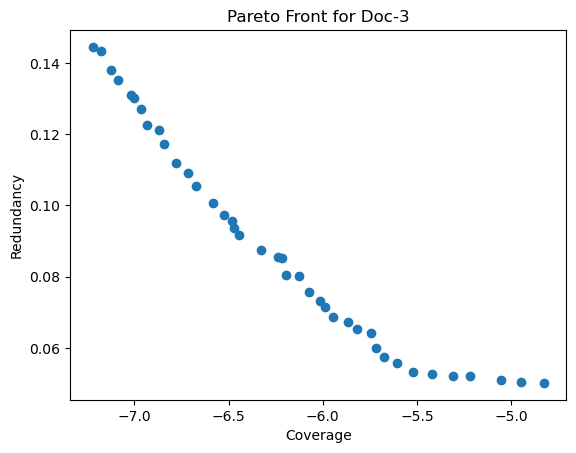

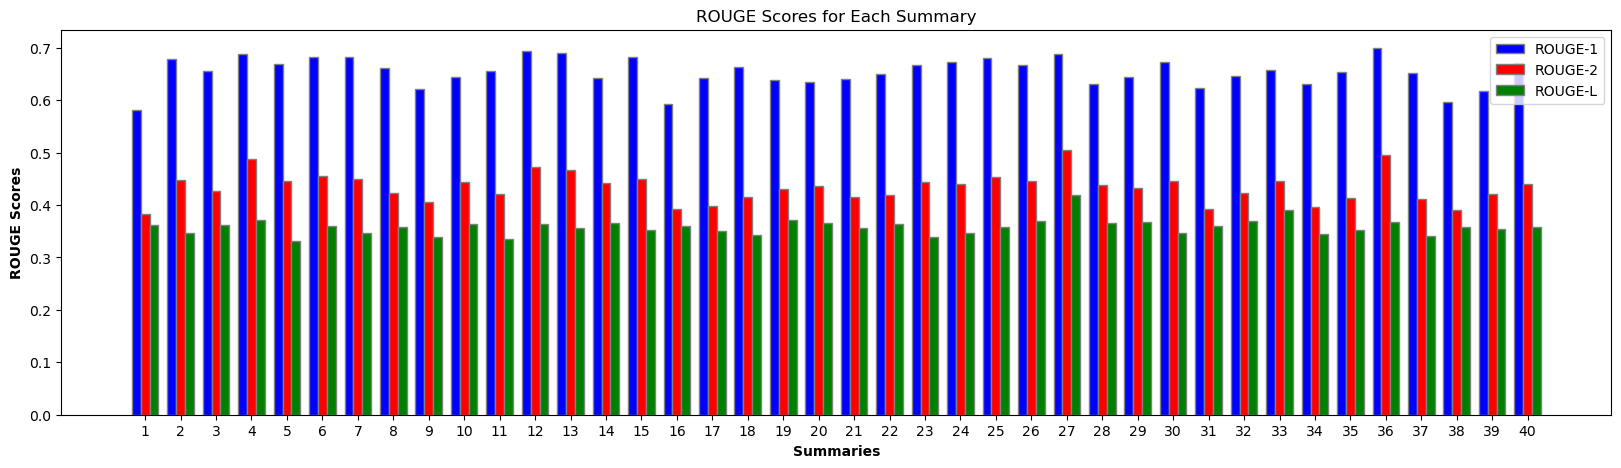

In [128]:
distance=[]
mean_std_hist=[]
mean_dis=[]
std_dis=[]
dissimilarity=[]
rouge_max=[]
result=[]
histo_f1=[]
parent_population = []
child_population = []
df = get_sol2(texts[1],texts_summ[1])

In [79]:
df.to_csv("C:/Users/Yogeshwar/Desktop/EMO/df.csv")

In [132]:
num=df['ROUGE-1'].max()
df1=df[df["ROUGE-1"]==num]
df1.head()

,Summary,ROUGE-1,ROUGE-2,ROUGE-L
35,36,0.699555,0.495917,0.367953


In [29]:
import pandas as pd 
df = pd.DataFrame()
df['distance']=distance
df['mean']=mean_dis
df['std']=std_dis

In [31]:
# Add an index column
df = df.reset_index()
df.rename(columns={'index': 'index'}, inplace=True)

print(df.head())


   index  distance      mean       std
0      0  0.636890  0.091462  0.029457
1      1  0.605318  0.037838  0.010180
2      2  0.193108  0.059739  0.024494
3      3  0.487103  0.009173  0.015418
4      4  0.768837  0.046800  0.023387


In [141]:
list2=[193,205,205,205,216,223,209,198,193,210,220,238,214,198,223,190,173,201,182,198]

In [143]:
list1=pd.DataFrame()
list1["No"]=list2
list1 = list1.reset_index()
list1.rename(columns={'index': 'index'}, inplace=True)

print(list1.head())

   index   No
0      0  193
1      1  205
2      2  205
3      3  205
4      4  216


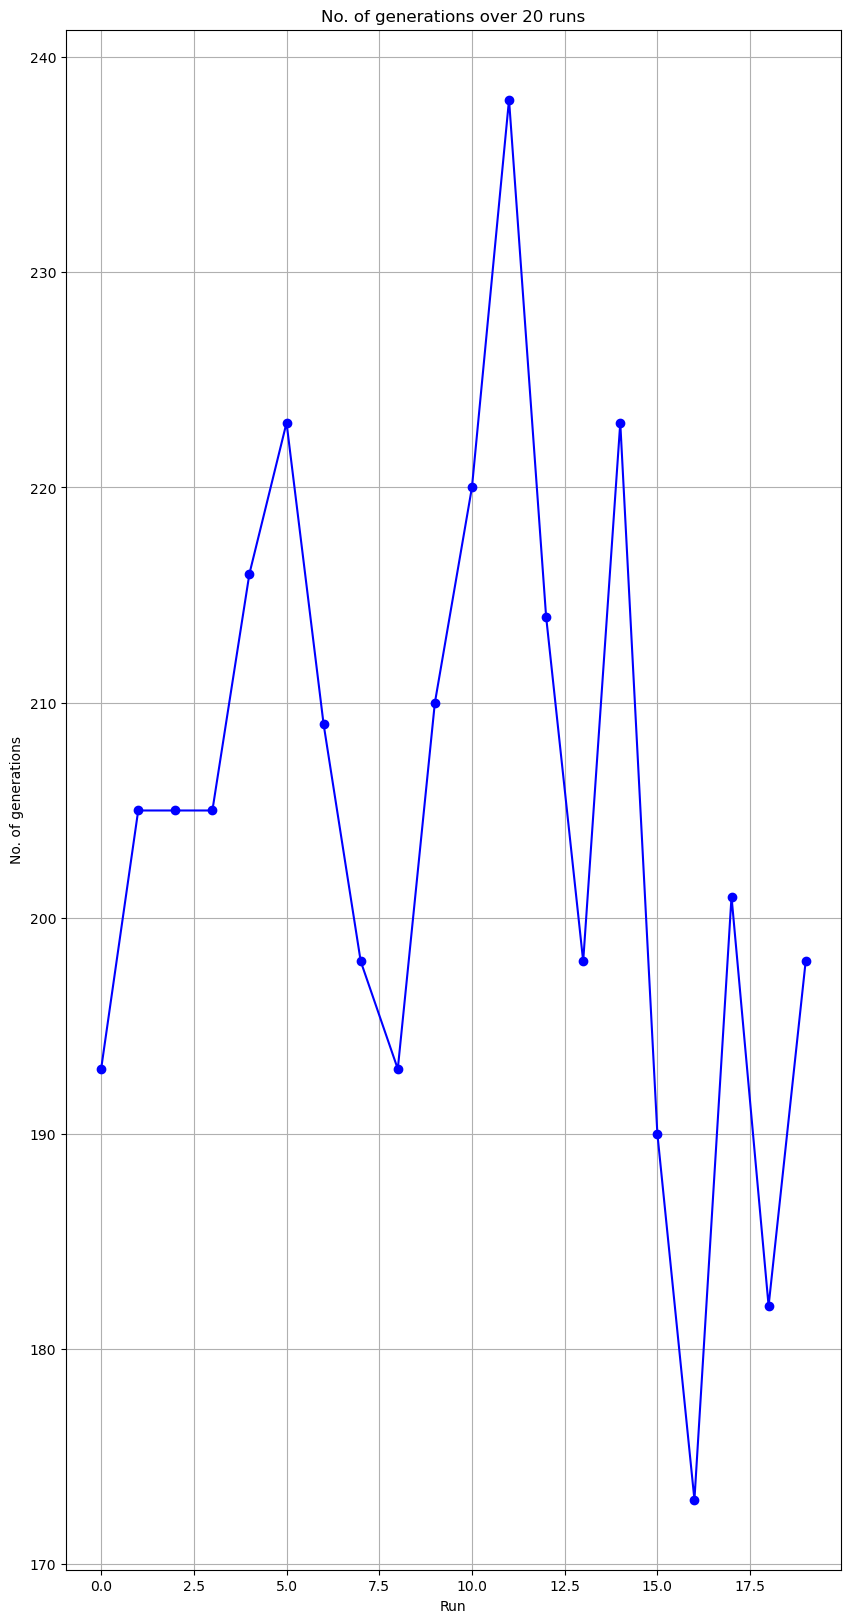

In [147]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 20))  # Single Axes object, not an array
ax.plot(list1['index'], list1['No'], marker='o', color='b')
ax.set_title('No. of generations over 20 runs')
ax.set_ylabel('No. of generations')
ax.set_xlabel('Run')
ax.grid(True)

plt.show()


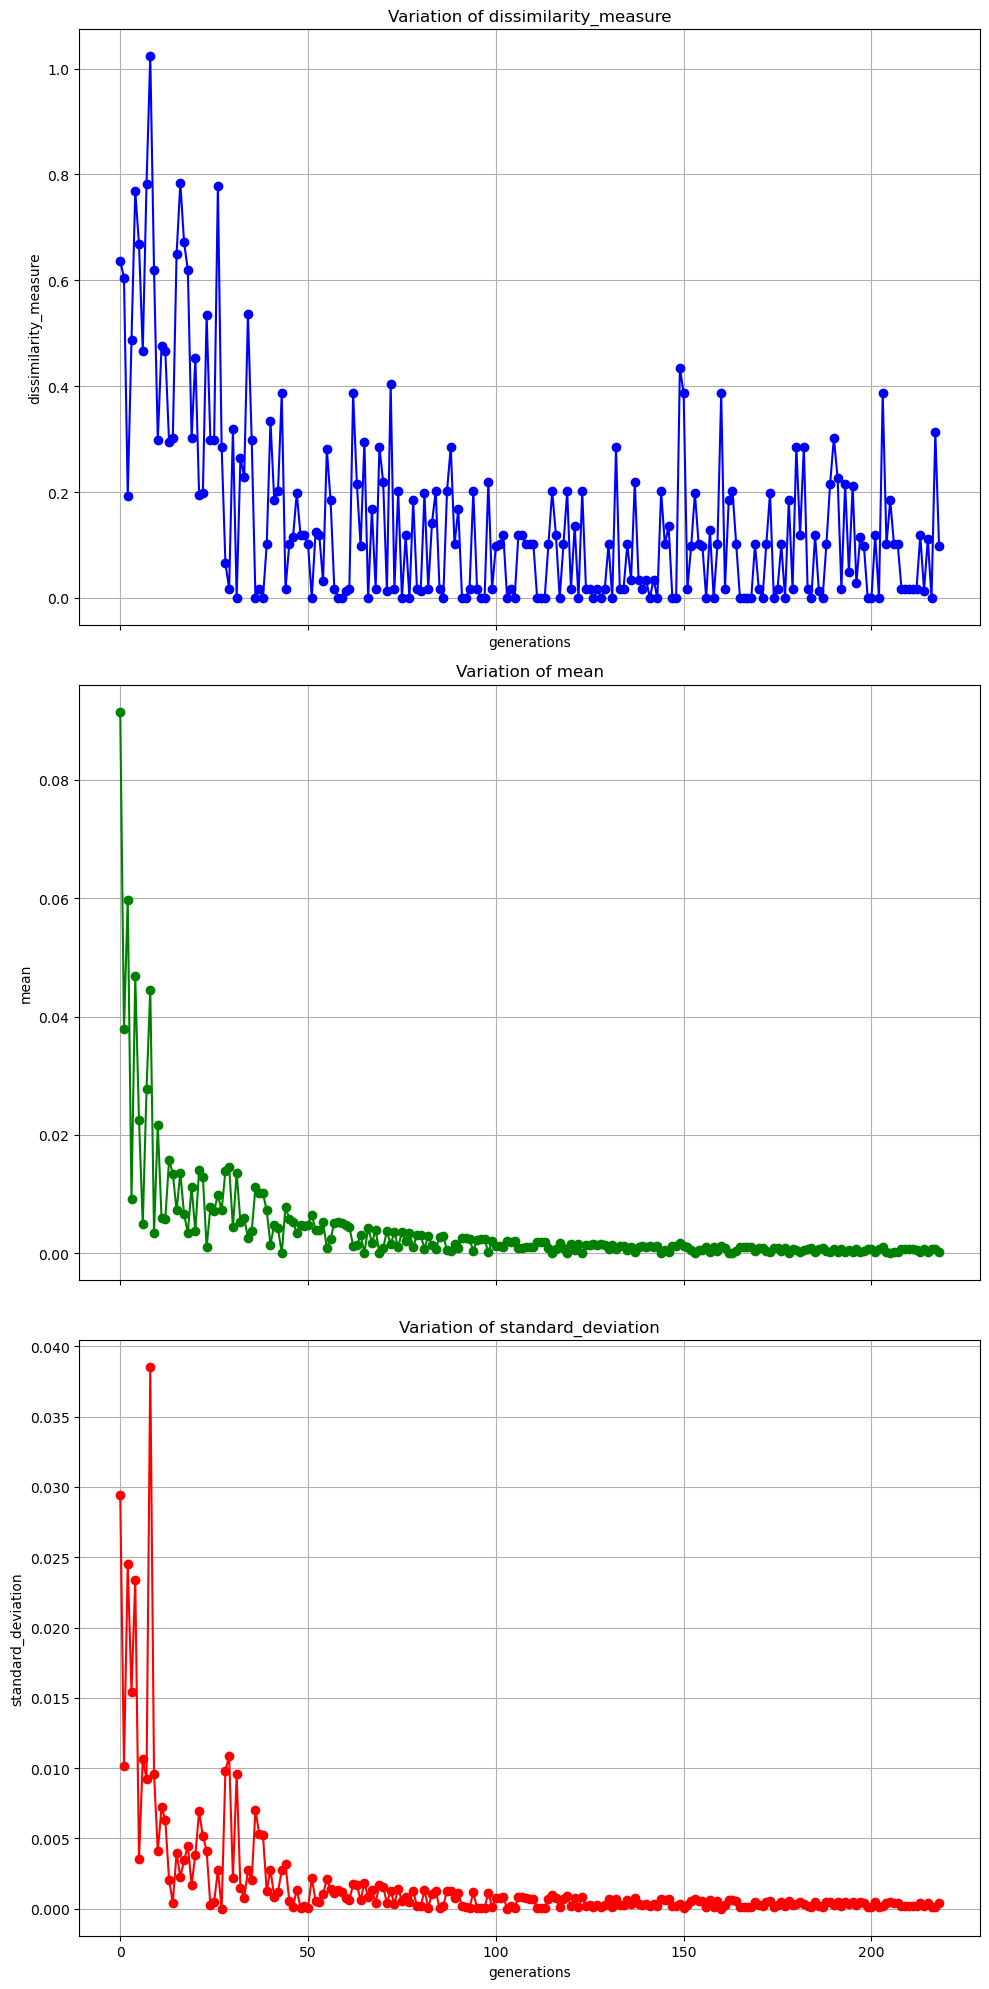

In [35]:
import matplotlib.pyplot as plt

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 20), sharex=True)

# Plot each quantity in a separate subplot
axs[0].plot(df['index'], df['distance'], marker='o', color='b')
axs[0].set_title('Variation of dissimilarity_measure')
axs[0].set_ylabel('dissimilarity_measure')
axs[0].set_xlabel('generations')
axs[0].grid(True)

axs[1].plot(df['index'], df['mean'], marker='o', color='g')
axs[1].set_title('Variation of mean')
axs[1].set_ylabel('mean')
axs[0].set_xlabel('generations')
axs[1].grid(True)

axs[2].plot(df['index'], df['std'], marker='o', color='r')
axs[2].set_title('Variation of standard_deviation')
axs[2].set_xlabel('generations')
axs[2].set_ylabel('standard_deviation')
axs[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

axs[0].plot(list1,# Show the plots
plt.show()



In [ ]:
df.to_csv("C:/Users/Yogeshwar/Desktop/EMO/df2.csv")

In [160]:
print(result)

[array([[ 0.05905623, -4.49837412],
       [ 0.15379607, -6.49253753],
       [ 0.06624511, -4.9793403 ],
       [ 0.10369787, -5.85759638],
       [ 0.06190781, -4.67010593],
       [ 0.12375825, -6.18026623],
       [ 0.14584421, -6.42057568],
       [ 0.09822393, -5.73338422],
       [ 0.07121912, -5.17733853],
       [ 0.0646757 , -4.83408016],
       [ 0.1094527 , -5.97296339],
       [ 0.08057557, -5.39018372],
       [ 0.14008627, -6.35769615],
       [ 0.11639533, -6.07682176],
       [ 0.13399853, -6.29476958],
       [ 0.12932604, -6.24314576],
       [ 0.08590302, -5.54876541],
       [ 0.07791533, -5.33985541],
       [ 0.07395896, -5.22068306],
       [ 0.09299302, -5.66221859]]), [array([-4.49837412, -6.49253753, -4.9793403 , -5.85759638, -4.67010593,
       -6.18026623, -6.42057568, -5.73338422, -5.17733853, -4.83408016,
       -5.97296339, -5.39018372, -6.35769615, -6.07682176, -6.29476958,
       -6.24314576, -5.54876541, -5.33985541, -5.22068306, -5.66221859]), array(

In [74]:
output_string = """
Number of objectives: 2
Number of bins: 20
Population size: 20
I: 0.000000e+00
O: 0.000000e+00
D: 0.000000e+00
"""
def parse_entropy_output(output):
        # Split the output into lines and parse each line
        lines = output.strip().split('\n')
        entropy_values = {}
        
        for line in lines:
            if line.startswith('I:'):
                entropy_values['I'] = float(line.split(':')[1].strip())
            elif line.startswith('O:'):
                entropy_values['O'] = float(line.split(':')[1].strip())
            elif line.startswith('D:'):
                entropy_values['D'] = float(line.split(':')[1].strip())
        
        # Debugging: print parsed values
        print("Parsed Entropy Values:", entropy_values)
        
        return entropy_values

d_value = parse_entropy_output(output_string)
print("Extracted D value:", d_value)
if 'D' not in d_value:
    print("Error: 'D' key not found in entropy_values.")
#                         return

Parsed Entropy Values: {'I': 0.0, 'O': 0.0, 'D': 0.0}
Extracted D value: {'I': 0.0, 'O': 0.0, 'D': 0.0}


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     18 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      120 |     18 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
Number of objectives: 2
Number of bins: 30
Population size: 20
I: 0.000000e+00
O: 0.000000e+00
D: 0.000000e+00

<class 'str'>
Parsed Entropy Values: {'I': 0.0, 'O': 0.0, 'D': 0.0}
     3 |      140 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0017810728 |             f
Number of objectives: 2
Number of bins: 30
Population size: 20
I: 0.000000e+00
O: 2.995732e-01
D: 2.995732e-01

<class 'str'>
Parsed Entropy Values: {'I': 0.0, 'O': 0.2995732, 'D': 0.2995732}
     4 |      160 |     20 |  0.000000E+00 |  0.000000E+00 |  0.1359355006 |         ideal
Number of objectives: 2
Number of bins: 30
Population size: 20
I: 3.465736e-02
O: 5.991465e-01
D: 6.338038e-01

<class 'str'>
Parsed Entropy Values: {'I': 0.03465736, 'O': 0

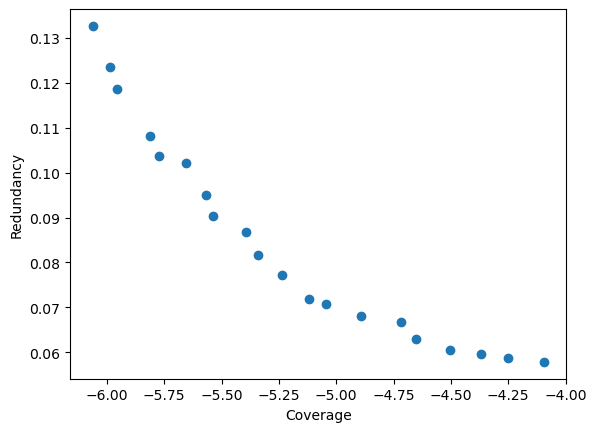

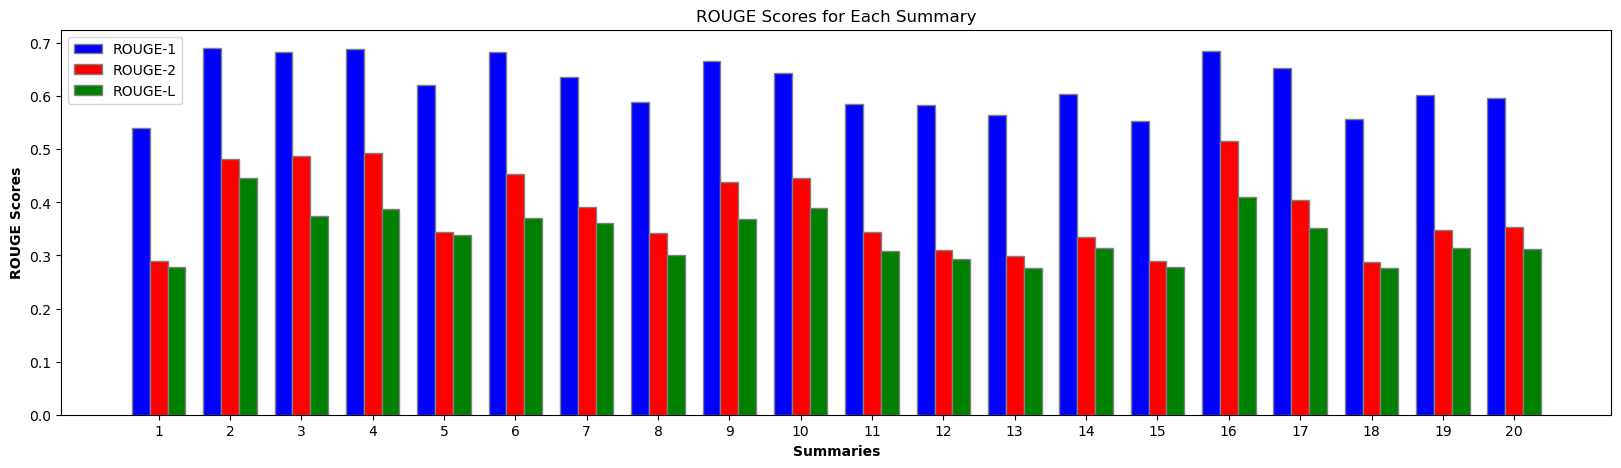

In [49]:
# for i in range(10):
#     get_sol(texts[i] , texts_summ[i])

get_sol(texts[0],texts_summ[0])

In [72]:
dissimilarity

[0.0,
 0.2995732,
 0.4594965,
 0.1671153,
 0.2995732,
 0.0,
 0.5991465,
 0.2995732,
 0.2995732,
 0.4941538,
 0.5991465,
 0.0,
 1.065835,
 0.3342306,
 0.5991465,
 0.5991465,
 0.4666885,
 0.4666885,
 0.4666885,
 0.0,
 0.3342306,
 0.0,
 0.1671153,
 0.3342306,
 0.829405,
 0.4666885,
 0.8987197,
 0.0,
 0.5298317,
 0.2995732,
 0.2995732,
 0.2017727,
 0.1671153,
 0.2995732,
 0.03465736,
 0.1671153,
 0.2995732,
 0.7662617,
 0.0,
 0.4666885,
 0.5991465,
 0.1671153,
 0.2995732,
 0.0,
 0.2995732,
 0.1671153,
 0.2995732,
 0.8987197,
 0.2995732,
 0.0,
 0.0,
 0.4666885,
 0.2995732,
 0.2995732,
 0.0,
 0.0,
 0.0,
 0.2995732,
 0.2995732,
 0.8987197,
 0.2995732,
 0.6338038,
 0.4666885,
 0.5991465,
 0.2995732,
 0.5991465,
 0.0,
 0.0,
 0.2995732,
 0.5991465,
 0.0,
 0.1671153,
 0.1671153,
 0.0,
 0.0,
 0.1671153,
 0.2995732,
 0.1671153,
 0.1599232,
 0.3342306,
 0.2995732,
 0.03465736,
 0.2995732,
 0.7662617,
 0.5991465,
 0.2995732,
 0.0,
 0.2995732,
 0.0,
 0.0,
 0.0,
 0.5991465,
 0.0,
 0.0,
 0.5991465,
 0.2

In [70]:
count=0
for i in dissimilarity :
    if i>=0 and i<0.04:
        count+=1
print(count)        

331


<function matplotlib.pyplot.show(close=None, block=None)>

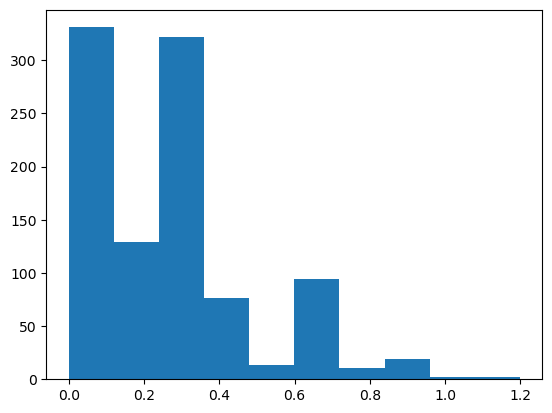

In [50]:
plt.hist(dissimilarity)
plt.show

In [162]:
get_sol(texts[0],texts_summ[0])

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     26 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      120 |     20 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
Number of objectives: 2
Number of bins: 20
Population size: 20
I: 0.000000e+00
O: 0.000000e+00
D: 0.000000e+00

<class 'str'>
Parsed Entropy Values: {'I': 0.0, 'O': 0.0, 'D': 0.0}
     3 |      140 |     20 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
Number of objectives: 2
Number of bins: 20
Population size: 20
I: 0.000000e+00
O: 0.000000e+00
D: 0.000000e+00

<class 'str'>
Parsed Entropy Values: {'I': 0.0, 'O': 0.0, 'D': 0.0}
Dissimilarity change: 0.0
Stopping criteria met. Terminating optimization.
     4 |      160 |     20 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
Number of objectives: 2
Number of bins: 20
Population size: 20
I: 0.000000e+00
O: 0.000000e+00
D: 0.000000e+00

KeyboardInterrupt: 

In [65]:
print(parent_population)

[array([[ 0.14370145, -6.2094813 ],
       [ 0.13415656, -6.14196734],
       [ 0.12678623, -5.97092423],
       [ 0.09819994, -5.55608885],
       [ 0.11502694, -5.81290653],
       [ 0.10714207, -5.71053975],
       [ 0.09847539, -5.56483739],
       [ 0.11527635, -5.82125348],
       [ 0.10876863, -5.78840121],
       [ 0.11897866, -5.9516358 ],
       [ 0.14045252, -6.19831523],
       [ 0.11678769, -5.91784101],
       [ 0.10700518, -5.68802767],
       [ 0.15214657, -6.30001342],
       [ 0.12985567, -6.05193892],
       [ 0.12339761, -5.96279763],
       [ 0.09974351, -5.68616673],
       [ 0.13469381, -6.07200481],
       [ 0.13526592, -6.09401759],
       [ 0.12688792, -5.96797285],
       [ 0.09915139, -5.56342377],
       [ 0.10982457, -5.71582944],
       [ 0.11479715, -5.77364833],
       [ 0.11022069, -5.74693983],
       [ 0.11338476, -5.75190736],
       [ 0.12094674, -5.91861173],
       [ 0.12179349, -5.92311074],
       [ 0.1419341 , -6.14868707],
       [ 0.14861154

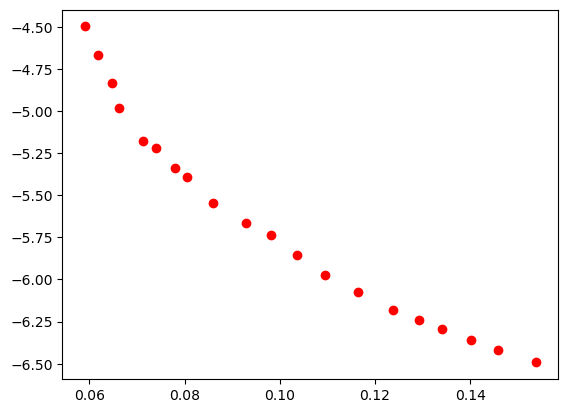

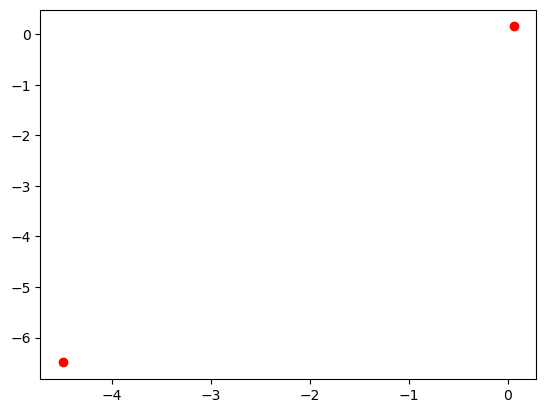

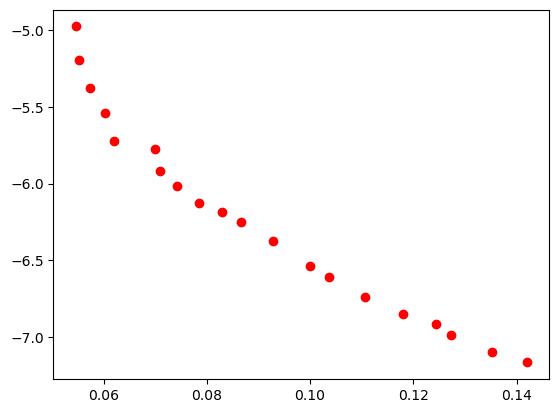

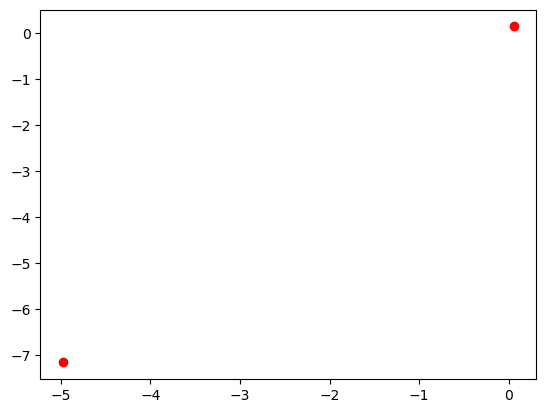

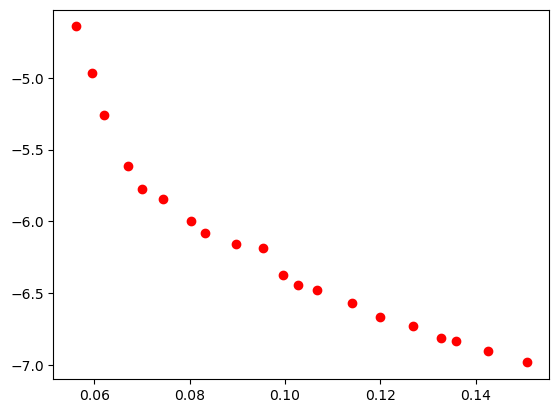

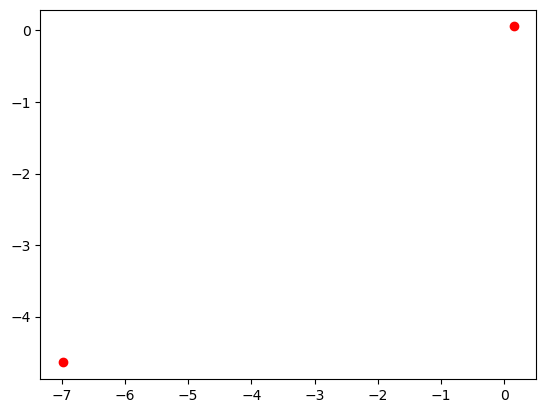

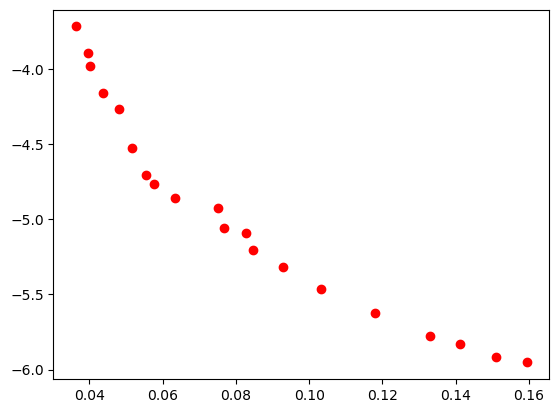

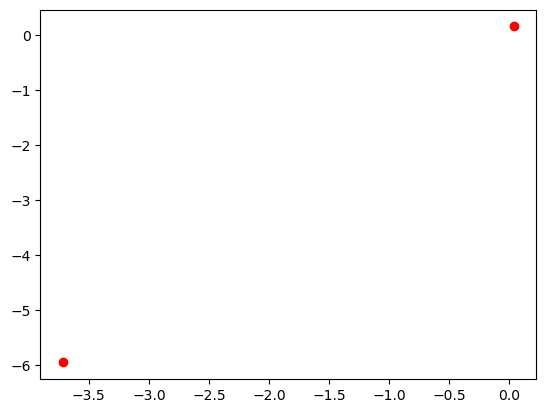

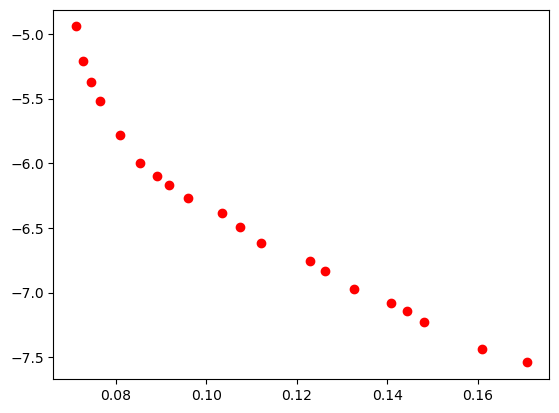

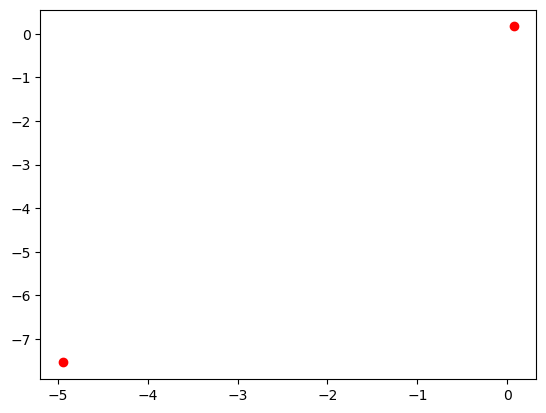

In [162]:
for i in range(10):
    data = np.array(result[i])
    plt.scatter(data[:, 0], data[:, 1], color='red')
    plt.show()

In [130]:
reference_point = []

In [146]:
def reference(text, reference):
    # Tokenize the input texts
    sentences_ref = sent_tokenize(reference)
    sentences = sent_tokenize(text)
    
    # Load the pre-trained model
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    
    # Encode sentences to get embeddings
    embeddings = model.encode(sentences)
    
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings)
    
    # Initialize decision vector
    n = len(sentences)
    decision_vector = np.zeros(n)
    
    # Debugging: Print tokenized sentences
    print("Sentences:", sentences)
    print("Reference Sentences:", sentences_ref)
    
    # Update decision vector
    for i in range(n):
        # Debugging: Print each sentence and check membership
        print(f"Checking if '{sentences[i]}' in reference sentences...")
        if sentences[i] in sentences_ref:
            print(f"'{sentences[i]}' is in reference sentences.")
            decision_vector[i] = 1
    
    # Print decision vector for debugging
    print("Decision Vector:", decision_vector)
    
    # Calculate coverage and redundancy
    coverage = calculate_coverage(similarity_matrix, decision_vector)
    redundancy = calculate_redundancy(similarity_matrix, decision_vector)
    
    # Append results to global list
    reference_point.append([coverage, redundancy])

In [148]:
for i in range(1):
    reference(texts[i] , texts_summ[i])

Sentences: ['Ad sales boost Time Warner profit  Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.', 'The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales.', 'TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.', 'Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.', 'Time Warner said on Friday that it now owns 8% of search-engine Google.', 'But its own internet business, AOL, had has mixed fortunes.', 'It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters.', "However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues.", "It hopes to increase subscribers by offering the online service free to TimeWarner internet c

20

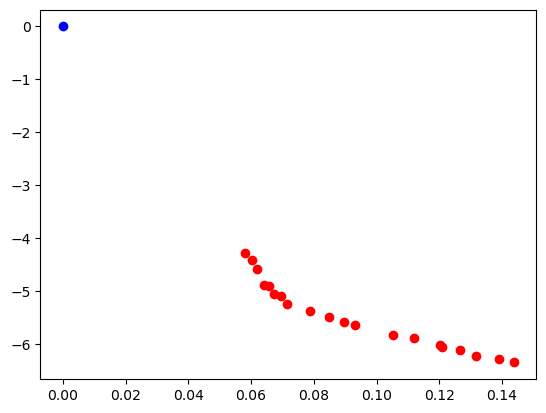

In [140]:
for i in range(1):
    plt.scatter(result[i][: ,0] , result[i][: ,1] , color = 'red')
    plt.show()
    

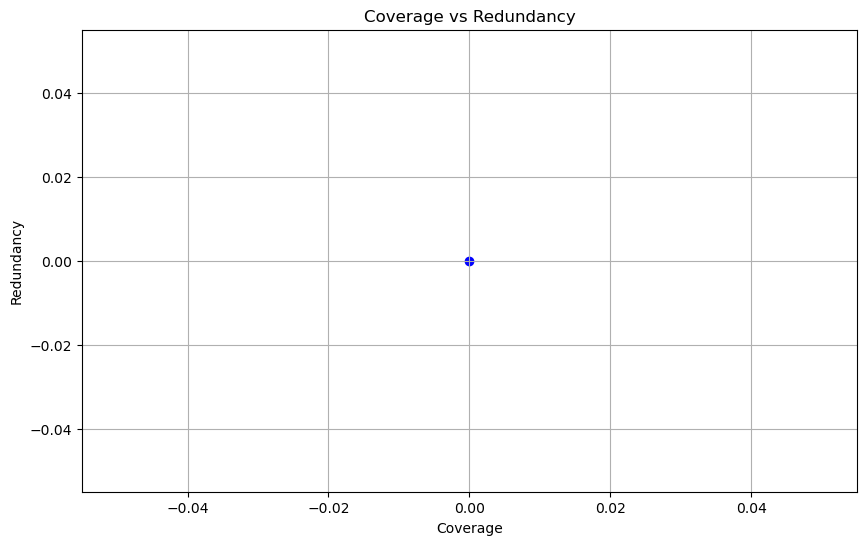

In [111]:


plt.figure(figsize=(10, 6))

plt.xlabel('Coverage')
plt.ylabel('Redundancy')
plt.title('Coverage vs Redundancy')
plt.grid(True)
plt.show()

In [106]:
len(result)

0

In [53]:
len(history1)

1000

In [56]:
n_evals = []             # corresponding number of function evaluations
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = [] 
for algo in history1:
    opt=algo.opt
    n_evals.append(algo.evaluator.n_eval)
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())


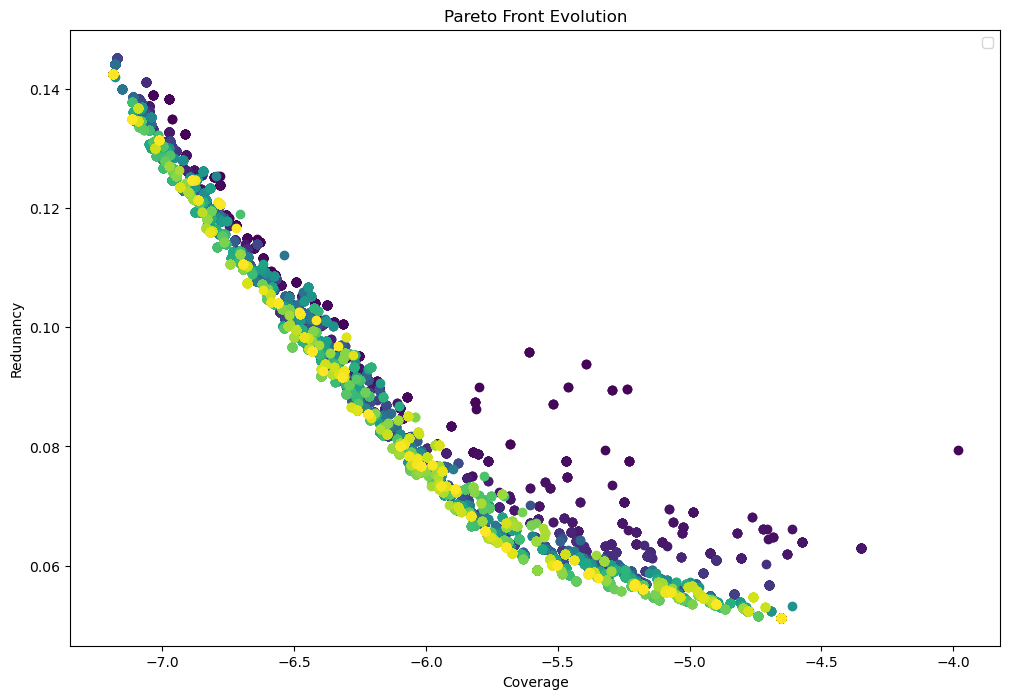

In [59]:
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(hist_F)))

for i, front in enumerate(hist_F):
    plt.scatter(front[:, 1], front[:, 0], color=colors[i])

plt.xlabel("Coverage")
plt.ylabel("Redunancy")
plt.title("Pareto Front Evolution")
plt.legend()
# plt.grid(True)
plt.show()


In [39]:
from pymoo.utils.plotting import plot_pareto_front, plot_convergence

# Extract the history
history = res.history

# Create a convergence plot
plt.figure(figsize=(10, 5))
plot_convergence(history)
plt.xlabel("Generation")
plt.ylabel("Hypervolume")
plt.title("Convergence Plot")
plt.grid()
plt.show()


ModuleNotFoundError: No module named 'pymoo.utils'

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     10 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      120 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0316922581 |         ideal
     3 |      140 |     12 |  0.000000E+00 |  0.000000E+00 |  0.1109050831 |         ideal
     4 |      160 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0047448181 |             f
     5 |      180 |     11 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |      200 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0144834748 |             f
     7 |      220 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0424227843 |         nadir
     8 |      240 |     11 |  0.000000E+00 |  0.000000E+00 |  0.1387428465 |         ideal
     9 |      260 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0138688499 |             f
    10 |      280 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0110466402 |             f

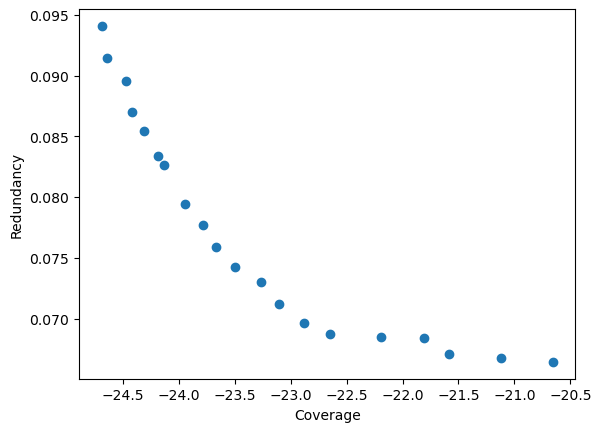

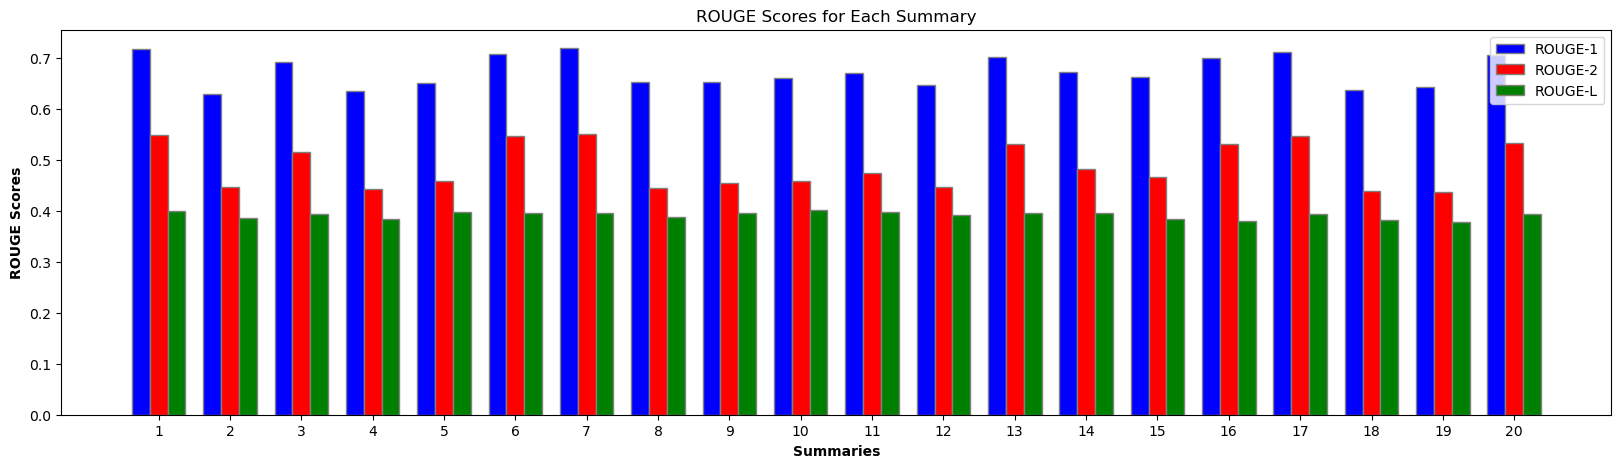

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      6 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      120 |      6 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     3 |      140 |      6 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     4 |      160 |      7 |  0.000000E+00 |  0.000000E+00 |  0.2337774215 |         ideal
     5 |      180 |     10 |  0.000000E+00 |  0.000000E+00 |  0.1020456689 |         ideal
     6 |      200 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0244967188 |             f
     7 |      220 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0728122012 |         ideal
     8 |      240 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0815968193 |         ideal
     9 |      260 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0344659046 |             f
    10 |      280 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0054879253 |             f

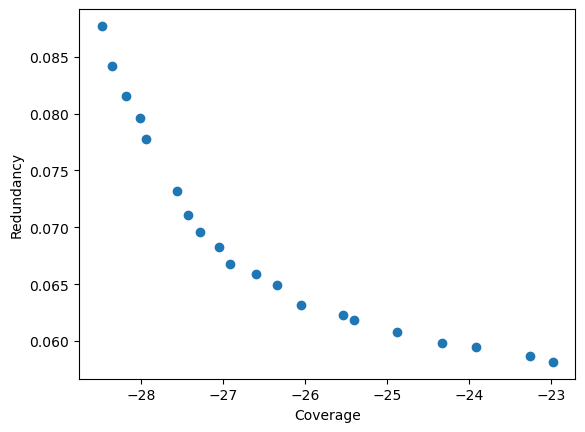

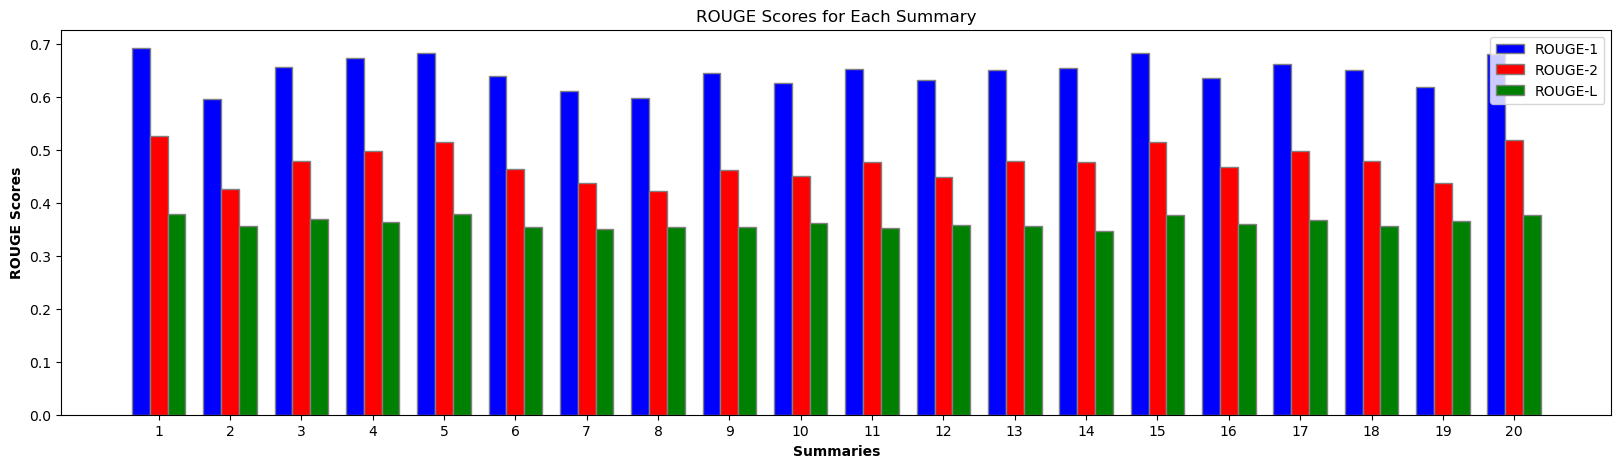

In [33]:
for i in range(1):
    get_sol(texts[i],texts_summ[i])

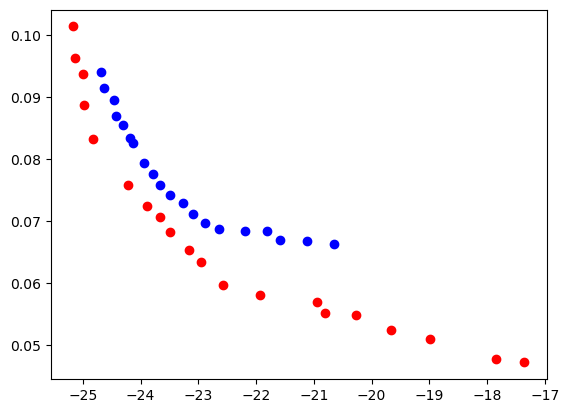

In [35]:
plt.scatter(result[0][0] , result[0][1] , color='red')
plt.scatter(result[1][0] , result[1][1] , color='blue')
plt.show()

In [37]:
paragraphs = [para.strip() for para in text2.split('\n') if para.strip()]

# Creating a list of dictionaries
data = [{'article_text': paragraph} for paragraph in paragraphs]

# Creating a DataFrame
text2 = pd.DataFrame(data)

In [38]:
text2

,article_text
0,Ad sales boost Time Warner profit Quarterly p...


In [7]:
data.shape

(2225, 2)

In [7]:
len(text1)

18057

In [8]:
len(reference)

7833

In [9]:
len(sentences)

130

In [12]:
!pip install sentence-transformers -q

In [15]:
!pip install tf_keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB 217.9 kB/s eta 0:00:08
    --------------------------------------- 0.0/1.7 MB 330.3 kB/s eta 0:00:06
   -- ------------------------------------- 0.1/1.7 MB 590.8 kB/s eta 0:00:03
   --- ------------------------------------ 0.2/1.7 MB 833.5 kB/s eta 0:00:02
   -------- ------------------------------- 0.4/1.7 MB 1.6 MB/s eta 0:00:01
   ------------- -------------------------- 0.6/1.7 MB 1.9 MB/s eta 0:00:01
   ---------------- ----------------------- 0.7/1.7 MB 2.0 MB/s eta 0:00:01
   ----------------- ---------------------- 0.8/1.7 MB 2.0 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 1.9 MB/s eta 0:00:01
   -------------------- ------------------- 0.9/1.7 MB 1.8 MB/s eta 0:00:01
   --------------------- ------------------ 0.9/1.7 MB 1.7 MB/s eta 0:00:01
   ---------------

C:\Users\Yogeshwar\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
print("\nPretty Printed Similarity Matrix:")
print("\t" + "\t".join([f"Sent {i+1}" for i in range(len(sentences))]))
for i, row in enumerate(similarity_matrix):
    print(f"Sent {i+1}\t" + "\t".join([f"{value:.2f}" for value in row]))

In [17]:
!pip install pymoo -q

In [19]:
import pickle

In [78]:
#IMPORTING NECESSARY THINGS
with open('C:/Users/Yogeshwar/Downloads/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
unique_list=pd.read_csv('C:/Users/Yogeshwar/Downloads/dataframe_data.csv')
unique_list = unique_list.iloc[:,0].tolist()
from keras.models import load_model
model=load_model('C:/Users/Yogeshwar/Downloads/word_importance2.keras')

In [79]:
unique_list

['sportscar',
 'villa',
 'alan',
 'network',
 'growers',
 'deutschland',
 'blot',
 'praising',
 'catching',
 'pervaded',
 'refute',
 'muzaffarabad',
 'youths',
 'katharine',
 'barking',
 'laureate',
 'bromesberrow',
 'battleship',
 'nearly',
 'mamas',
 'koo',
 'return',
 'muscle',
 'russia',
 'sienna',
 'abeyie',
 'complexion',
 'balfour',
 'thank',
 'experiments',
 'distances',
 'centrally',
 'chaplin',
 'casino',
 'acceleration',
 'shower',
 'vague',
 'fared',
 'browser',
 'unforced',
 'yet',
 'cookies',
 'fuels',
 'buoyancy',
 'ordinated',
 'booms',
 'rank',
 'blackbuck',
 'condoms',
 'amber',
 'credited',
 'presenting',
 'aiden',
 'viewed',
 'heathers',
 'epitestosterone',
 'prosper',
 'hoc',
 'efficiency',
 'misconduct',
 'monsanto',
 'platinum',
 'frigidaire',
 'mbita',
 'labadze',
 'promote',
 'baring',
 'consume',
 'microsoft',
 'mit',
 'administrative',
 'busier',
 'mittal',
 'collaborations',
 'kumaratunga',
 'emi',
 'demerged',
 'trait',
 'crippled',
 'seeker',
 'locations',

In [80]:
import pandas as pd
from collections import Counter
def coverage_using_ann(txt):
    word_df = pd.DataFrame(columns=unique_list) #unique_list2 is given as a df, make a list titled unique_list
    word_count = Counter(txt.split()) # Count the occurrences of each word in the text
    for word, count in word_count.items():
        if word in unique_list:
            word_df.loc[0, word] = count #Making dataframe for model to make predictions on
    word_df=scaler.fit_transform(word_df) # scaler is also saved using pickle library
    pred=model.predict(word_df) #make predictions
    final=list(pred) #making list
    word_count_dict = {word: count for word, count in zip(unique_list, final[0])} # making a dictionary using prediction and unique_list
    txt_list=[]
    sent_value=[]
    sentences=nltk.sent_tokenize(txt) #txt is the raw text
    for i in range(len(sentences)):
        value=0
        for word in sentences[i]: # next lines are self explanatory
            if word in word_count_dict:
                value=value+word_count_dict[word]
            elif word in stop_words:
                value=value+0.05
            else :
                value=value+0.2
        value=value/len(sentences[i])
        sent_value.append(value)
    return sent_value

In [81]:
import io


In [99]:
word_df = pd.DataFrame(columns=unique_list) #unique_list2 is given as a df, make a list titled unique_list
word_count = Counter(text2.iloc[0,0].split()) # Count the occurrences of each word in the text
for word, count in word_count.items():
    if word in unique_list:
        word_df.loc[0, word] = count #Making dataframe for model to make predictions on
#word_df=scaler.fit_transform(word_df)

In [100]:
word_df

,sportscar,villa,alan,network,growers,deutschland,blot,praising,catching,pervaded,...,hardly,anonymously,afford,breaches,mistake,sidoli,traditional,cited,artists,mallon
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
word_df=scaler.fit_transform(word_df)

C:\Users\Yogeshwar\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Yogeshwar\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [95]:
max_values=word_df.max(axis=1)

In [97]:
max_values

array([nan])

In [83]:
#calculate_coverage=coverage_using_ann(text2.iloc[0,0])

In [14]:
similarity_matrix.shape

(130, 130)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     10 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      120 |     10 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     3 |      140 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0897638521 |         ideal
     4 |      160 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0163068931 |             f
     5 |      180 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0048451353 |             f
     6 |      200 |     13 |  0.000000E+00 |  0.000000E+00 |  0.1329791753 |         ideal
     7 |      220 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0199852292 |             f
     8 |      240 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0283997636 |             f
     9 |      260 |     12 |  0.000000E+00 |  0.000000E+00 |  0.1126145437 |         ideal
    10 |      280 |     14 |  0.000000E+00 |  0.000000E+00 |  0.0081296239 |             f

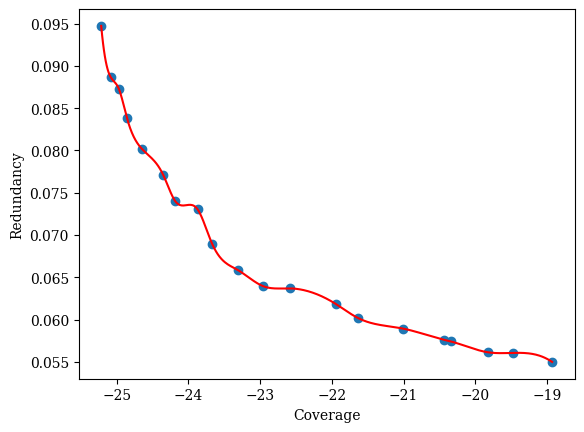

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Example data points (replace with actual data)
# Redundancy
f1=res.F[: , 1]
# Coverage 
f2= res.F[ : , 0]
# f2 = np.array([-18, -19, -20, -21, -22, -23, -24, -25])

# Interpolation
interpolator = interp1d(f1, f2, kind='cubic')
f1_continuous = np.linspace(f1.min(), f1.max(), 500)
f2_continuous = interpolator(f1_continuous)

# Plot
plt.scatter(f1, f2)
plt.plot(f1_continuous, f2_continuous, color='red')
plt.xlabel('Coverage')
plt.ylabel('Redundancy')
plt.show()


In [70]:
res.F[: ,1]

array([-24.99562535, -18.22662318, -18.85049057, -19.51433498,
       -21.73075762, -21.19114468, -20.60097826, -20.06136531,
       -24.73259562, -24.9217912 , -24.84626859, -24.80811822,
       -23.76030764, -23.47679582, -24.54013187, -24.42520422,
       -23.87555671, -22.39631322, -24.22706845, -24.09263763])

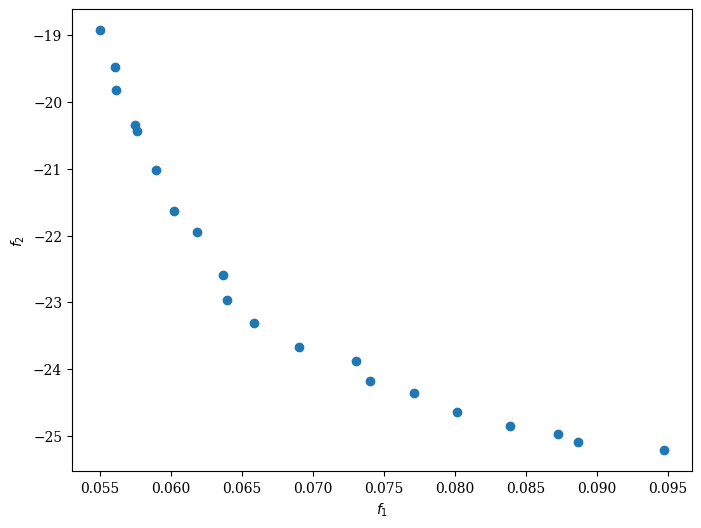

In [42]:


# Print the summaries
# print("\nGenerated Summaries:")
# for idx, summary in enumerate(summaries):
#     print(f"Summary {idx + 1}: {summary}")


In [24]:
!pip install rouge-score


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6d3ff238fbe832db260e7a1886bc1d899a75abf0115795e02d0263dfa3ccdbb5
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [44]:
df['ROUGE-1'].max()

0.7269681742043551

In [27]:
summary = sent_tokenize(summaries[9])

In [28]:
len(summary)

43

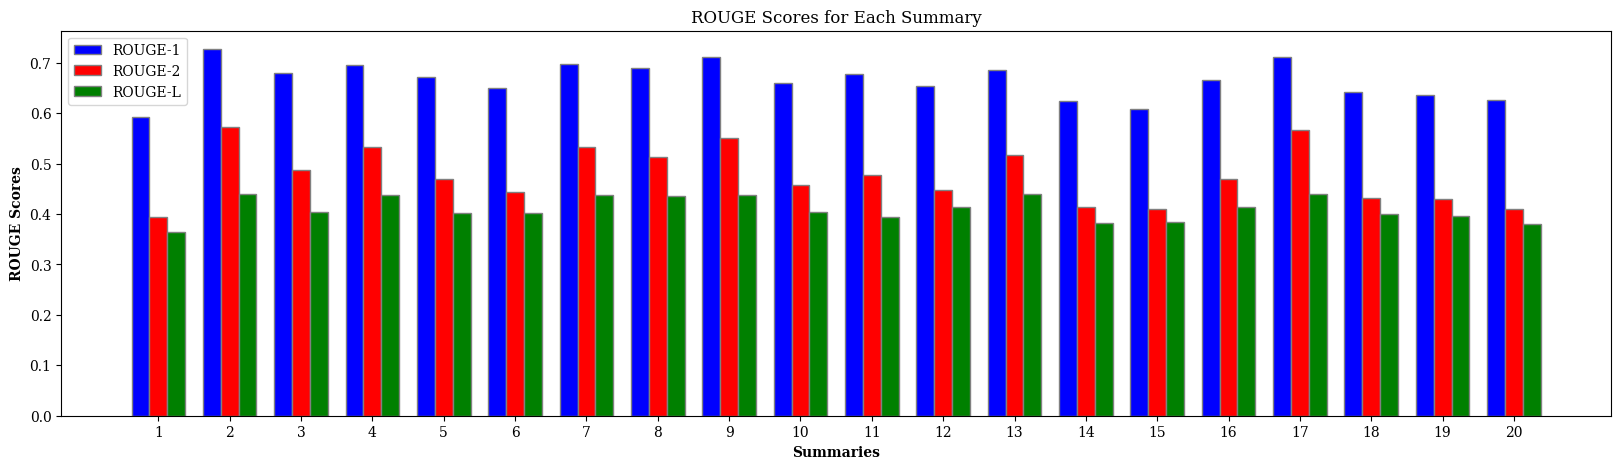

In [45]:
from pymoo.visualization.scatter import Scatter
    Scatter().add(res.F).show()